In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


import warnings

In [2]:
# PARAMETERS
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 4  

In [23]:
# DATA PREPARATION
train_data_dir =r'C:\\Users\\Siddhant\\Downloads\\archive\\train'
val_data_dir = r'C:\\Users\\Siddhant\\Downloads\\archive\\val'
test_data_dir = r'C:\\Users\\Siddhant\\Downloads\\archive\\test'
classes = os.listdir(train_data_dir)  # List of class names

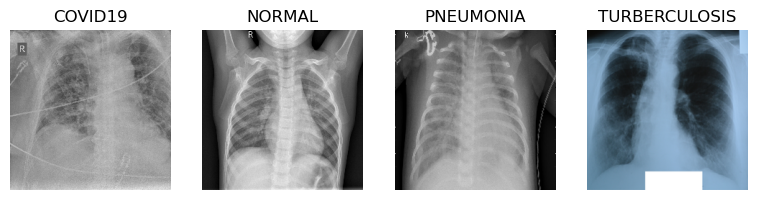

In [25]:
# Plot sample images from each class
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(classes[:5]):  # Display max 5 classes
    class_path = os.path.join(train_data_dir, class_name)
    image_name = os.listdir(class_path)[0]  # Pick the first image
    img = load_img(os.path.join(class_path, image_name), target_size=(224, 224))
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.show()

C:\Users\Siddhant\AppData\Local\Temp\ipykernel_13976\952033418.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")


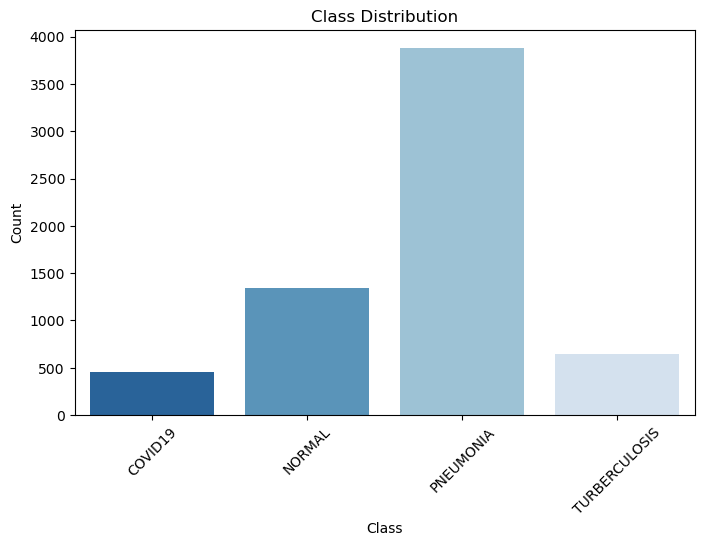

In [26]:
# Count number of images per class
class_counts = {cls: len(os.listdir(os.path.join(train_data_dir, cls))) for cls in classes}

# Convert to DataFrame
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x="Class", y="Count", data=df, palette="Blues_r")
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

In [27]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


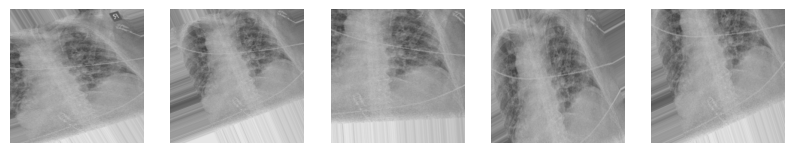

In [28]:
# Define an ImageDataGenerator for augmentation
augmentor = ImageDataGenerator(
    rotation_range=30,        # Rotate the image by up to 30 degrees
    width_shift_range=0.2,    # Shift the image horizontally by up to 20%
    height_shift_range=0.2,   # Shift the image vertically by up to 20%
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Zoom in or out by up to 20%
    horizontal_flip=True,     # Randomly flip the image horizontally
    fill_mode="nearest"       # Fill missing pixels with nearest values
)

# Load a sample image
sample_img_path = os.path.join(train_data_dir, classes[0], os.listdir(os.path.join(train_data_dir, classes[0]))[0])
img = load_img(sample_img_path, target_size=(224, 224))  # Resize image if necessary
img_array = img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Generate augmented images
plt.figure(figsize=(10, 5))
for i, batch in enumerate(augmentor.flow(img_array, batch_size=1)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0].astype("uint8"))  # Convert image back to uint8 format for visualization
    plt.axis("off")
    if i == 4:  # Show 5 augmented images
        break

plt.show()

In [30]:
# HELPER FUNCTION TO BUILD MODELS
def build_transfer_model(base_model, num_classes, freeze_layers=True):
    if freeze_layers:
        for layer in base_model.layers:
            layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [31]:
# Custom CNN Model
def build_custom_cnn(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [32]:
# Model Dictionary
models_to_train = {
    'VGG16': (build_transfer_model(VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), NUM_CLASSES), SGD(learning_rate=1e-3)),
    'ResNet50': (build_transfer_model(ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), NUM_CLASSES), RMSprop(learning_rate=1e-4)),
    'DenseNet121': (build_transfer_model(DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), NUM_CLASSES), Adam(learning_rate=1e-4)),
    'MobileNet': (build_transfer_model(MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), NUM_CLASSES), Adam(learning_rate=1e-4)),
    'Custom_CNN': (build_custom_cnn(NUM_CLASSES), Adam(learning_rate=1e-4))
}

C:\Users\Siddhant\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [38]:
# Loop through each model in the dictionary and train
for model_name, (model, optimizer) in models_to_train.items():
    print(f"Starting training for model: {model_name}")
    history = train_and_evaluate(model, optimizer, model_name)
    
    # Optional: Save the trained model
    model.save(f"{model_name}_trained_model.h5")
    
    # Optional: Plot the training history
    if history:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        
        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f"{model_name} Accuracy")
        plt.legend()
        
        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"{model_name} Loss")
        plt.legend()
        
        plt.show()


Starting training for model: VGG16
Training VGG16...
Epoch 1/20


C:\Users\Siddhant\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.5106 - loss: 1.1968 - val_accuracy: 0.2105 - val_loss: 1.7621
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.6042 - loss: 1.0798 - val_accuracy: 0.2105 - val_loss: 1.7813
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.6156 - loss: 1.0622 - val_accuracy: 0.2105 - val_loss: 1.7694
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.6117 - loss: 1.0504 - val_accuracy: 0.2105 - val_loss: 1.7836


Starting training for model: ResNet50
Training ResNet50...
Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.3020 - loss: 1.6570 - val_accuracy: 0.2105 - val_loss: 1.9495
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.5955 - loss: 1.1309 - val_accuracy: 0.2105 - val_loss: 1.9363
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.6076 - loss: 1.1135 - val_accuracy: 0.2105 - val_loss: 1.9103
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.6113 - loss: 1.0846 - val_accuracy: 0.2105 - val_loss: 1.8841
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.6138 - loss: 1.0672 - val_accuracy: 0.2105 - val_loss: 1.8858
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.6227 - loss: 1.0455 - val_accuracy: 0.2105 - val_loss: 1.8075
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6174 - loss: 1.0457 - val_accuracy: 0.2105 - val_loss: 1.8033
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━

Starting training for model: DenseNet121
Training DenseNet121...
Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - accuracy: 0.4373 - loss: 1.5454 - val_accuracy: 0.2105 - val_loss: 1.7556
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.5922 - loss: 1.0436 - val_accuracy: 0.2895 - val_loss: 1.4497
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 543s 3s/step - accuracy: 0.6686 - loss: 0.8328 - val_accuracy: 0.5000 - val_loss: 1.2821
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.7124 - loss: 0.7033 - val_accuracy: 0.5263 - val_loss: 1.1186
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 599s 3s/step - accuracy: 0.7427 - loss: 0.6411 - val_accuracy: 0.6053 - val_loss: 1.0666
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.7582 - loss: 0.5795 - val_accuracy: 0.6053 - val_loss: 0.9687
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.8017 - loss: 0.5089 - val_accuracy: 0.6316 - val_loss: 0.9289
Epoch 8/20
198/198 ━━━━━━━━━━━━━

Starting training for model: MobileNet
Training MobileNet...
Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 160s 768ms/step - accuracy: 0.4198 - loss: 1.6914 - val_accuracy: 0.2368 - val_loss: 1.5501
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 152s 750ms/step - accuracy: 0.6199 - loss: 0.9871 - val_accuracy: 0.5000 - val_loss: 1.1670
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 153s 756ms/step - accuracy: 0.7187 - loss: 0.7505 - val_accuracy: 0.5789 - val_loss: 0.9535
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 152s 750ms/step - accuracy: 0.7648 - loss: 0.6312 - val_accuracy: 0.6842 - val_loss: 0.7972
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 152s 751ms/step - accuracy: 0.8008 - loss: 0.5145 - val_accuracy: 0.7105 - val_loss: 0.7263
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 153s 757ms/step - accuracy: 0.8403 - loss: 0.4308 - val_accuracy: 0.7895 - val_loss: 0.6477
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 154s 760ms/step - accuracy: 0.8290 - loss: 0.4374 - val_accuracy: 0.7895 - val_loss: 0.6045
Epoch 8/20
198/

Starting training for model: Custom_CNN
Training Custom_CNN...
Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 180s 883ms/step - accuracy: 0.6536 - loss: 0.9164 - val_accuracy: 0.5263 - val_loss: 1.8181
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 174s 860ms/step - accuracy: 0.7989 - loss: 0.5223 - val_accuracy: 0.6579 - val_loss: 0.8784
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.8505 - loss: 0.4078 - val_accuracy: 0.8158 - val_loss: 0.5231
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.8568 - loss: 0.3914 - val_accuracy: 0.7632 - val_loss: 0.5808
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.8772 - loss: 0.3486 - val_accuracy: 0.7105 - val_loss: 0.7451
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.8817 - loss: 0.3307 - val_accuracy: 0.7368 - val_loss: 0.5323


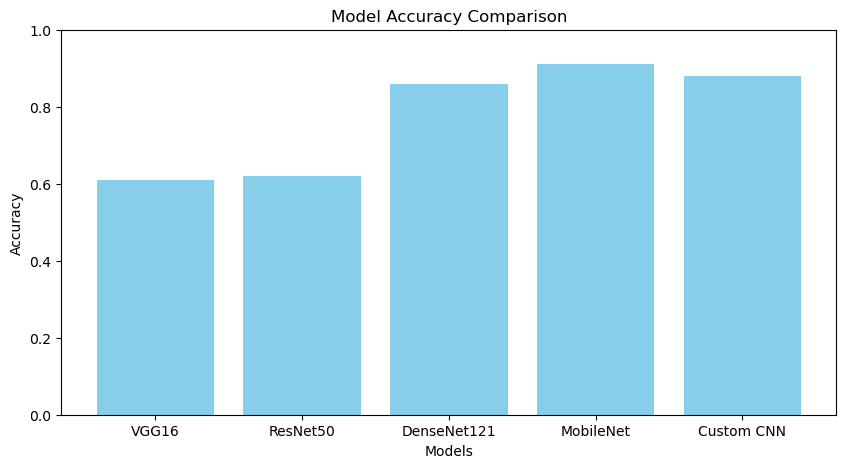

In [60]:
import matplotlib.pyplot as plt

# Example Data
model_names = ['VGG16', 'ResNet50', 'DenseNet121', 'MobileNet', 'Custom CNN']
accuracies = [0.61, 0.62, 0.86, 0.91, 0.8]

# Plot Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()
